In [342]:
import time
import numpy as np
from matplotlib import pyplot as plt
from rp_overlay import overlay
import rp
from scipy.fft import fft, fftfreq, ifft
from scipy.signal import get_window
from scipy.signal import kaiser
from scipy.signal import correlate, correlation_lags
import scipy.signal as signal
from scipy.signal import find_peaks
from scipy.signal import hilbert
import csv
from datetime import datetime

import os

fpga = overlay()
rp.rp_Init()

Check FPGA [OK].


0

In [343]:
#### setting parameters ####
channel = rp.RP_CH_1           # Output channel for the chirp
waveform = rp.RP_WAVEFORM_ARBITRARY

delay = 0
image = "none"
SignalL = "5" ### 1 for linear chirp, 2 for tone burst, 3 for sine, 4 for tone burst in cycles, 5 for m-sequence

#### signal generation ####
# Number of samples in the arb buffer
N = 16384
N_chirp = 10000
dec = rp.RP_DEC_128
sampling_rate = (125/128)*1e6
fs = sampling_rate
T = 10000 / sampling_rate
chirp_buffer = rp.arbBuffer(N_chirp)
t = np.linspace(0, T, N_chirp)
signal_amplitude = 0.3
num_cycles = 15

if SignalL == "1":
    # Chirp start and end frequencies
    f_start = 35000                
    f_end   = 45000                
    phase = 2 * np.pi * ( f_start * t + ((f_end - f_start) / (2 * T)) * t**2 )
    # Generate the chirp signal
    f_inst = f_start + ((f_end - f_start) / T) * t

    # Create the window: constant 1 when f_inst is outside 39-41 kHz, 0.5 when inside.
    # window = np.where((f_inst >= 39000) & (f_inst <= 41000), 0.5, 1.0)

    # Generate the chirp signal with the window applied
    chirp_signal = signal_amplitude * np.sin(phase)


elif SignalL == "2":
    f_burst = 40000
    # Generate the tone burst using a sine wave modulated by a Hanning window
    hanning_window = np.hanning(N_chirp)

    scaled_window = 0 + 1 * hanning_window  # Now starts at 0.4 and peaks at 1.0

    chirp_signal = signal_amplitude * np.sin(2 * np.pi * f_burst * t) * scaled_window

    chirp_signal_cc = signal.hilbert(chirp_signal)
    envelope_cc = np.abs(chirp_signal_cc)

elif SignalL == "3":
    freq = 40000
    samples_per_cycle = int(round(sampling_rate / freq))
    pulse_length = samples_per_cycle * num_cycles
    
    # Time vector for the pulse
    t_pulse = np.arange(pulse_length) / sampling_rate
    
    # Generate a sine wave for the chosen frequency
    raw_sine = np.sin(2 * np.pi * freq * t_pulse)

    chirp_signal = np.zeros(N_chirp)
    chirp_signal[:pulse_length] = raw_sine


elif SignalL == "4":
    freq = 40000
    samples_per_cycle = int(round(sampling_rate / freq))
    pulse_length = samples_per_cycle * num_cycles
    
    # Time vector for the pulse
    t_pulse = np.arange(pulse_length) / sampling_rate
    
    # Generate a sine wave for the chosen frequency
    raw_sine = np.sin(2 * np.pi * freq * t_pulse)
    
    # Create a Hanning window that matches the pulse length
    # (np.hanning returns a symmetric window from 0 to 1 to 0)
    window = np.hanning(pulse_length)
    
    # Multiply sine wave by the window to get a tapered tone burst
    burst = signal_amplitude * raw_sine * window
    
    # Place burst into your output array
    chirp_signal = np.zeros(N_chirp)
    chirp_signal[:pulse_length] = burst


elif SignalL == "5":
    # Generate linear chirp (35 kHz to 45 kHz)
    f_start = 35000  # Start frequency (Hz)
    f_end = 45000  # End frequency (Hz)
    chirp_signal = np.sin(2 * np.pi * (f_start * t + ((f_end - f_start) / (2 * T)) * t**2))
    
    # Compute FFT of both signals
    chirp_fft = fft(chirp_signal)
    
    # Define chirp parameters
    f_start = 35000                # 35 kHz
    f_end   = 45000                # 45 kHz
    phase = 2 * np.pi * ( f_start * t + ((f_end - f_start) / (2 * T)) * t**2 )
    # Generate the linear chirp signal
    chirp_signal = signal_amplitude * np.sin(phase)

    def generate_m_sequence(length, degree=14, taps=[14, 13]):
        # Maximum sequence length for the given degree
        max_length = 2**degree - 1  # 16383 for degree=14

        # Initialize shift register (must be nonzero)
        reg = np.ones(degree, dtype=int)
        seq = []
    
        for i in range(max_length):  # Generate full sequence first
            # Compute new bit (XOR of the tap positions)
            new_bit = np.mod(np.sum(reg[np.array(taps) - 1]), 2)
            # Append the last bit of the shift register to the sequence
            seq.append(reg[-1])
            # Shift register: shift right and insert new_bit at position 0
            reg[1:] = reg[:-1]
            reg[0] = new_bit
    
        # Convert binary {0,1} to bipolar {-1,1}
        seq = 2 * np.array(seq) - 1
    
        # Return only the first `length` samples
        return seq[:length]


    # Generate M-sequence of length equal to N_chirp
    m_seq = generate_m_sequence(N_chirp)
    
    m_seq_fft = fft(m_seq)
    
    conv_fft = chirp_fft * m_seq_fft
    
    # Compute IFFT to get time-domain result
    chirp_signal = ifft(conv_fft).real / 250  # Take the real part



trig_lvl = 0.01
trig_dly = 8194 - delay

acq_trig_sour = rp.RP_TRIG_SRC_AWG_PE


# User-defined noise amplitude
noise_amplitude = 0

# Generate white Gaussian noise
noise = noise_amplitude * np.random.normal(0, 1, len(t))/4


# plt.plot(envelope_cc)
# plt.show()

In [344]:
# Create the noisy signal (chirp + interference)
noisy_signal = chirp_signal + noise

for i in range(N_chirp): 
    chirp_buffer[i] = float(noisy_signal[i])


N_chirp = len(noisy_signal)
T_s = 1.0 / sampling_rate  # sampling period
yf_chirp = fft(noisy_signal)            # complex FFT result
xf_chirp = fftfreq(N_chirp, T_s)        # frequency bins from -Fs/2..+Fs/2

# Keep only the positive half for a real-valued signal
N_half_chirp = N_chirp // 2
xf_chirp_pos = xf_chirp[:N_half_chirp]
yf_chirp_pos = yf_chirp[:N_half_chirp]

# Convert to magnitude
mag_chirp = np.abs(yf_chirp_pos)

if image == "show":
    plt.figure(figsize=(5, 3))
    
    # Linear magnitude
    plt.plot(xf_chirp_pos, mag_chirp, label="Generated Chirp", linewidth=1.2)
    
    ## range
    plt.xlim(20e3, 70e3)
    
    plt.title("Chirp: Frequency-Domain Comparison")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    plt.plot(noisy_signal)
    plt.show()

    plt.plot(noisy_signal[0:200])
    plt.show()

In [345]:
display_duration = 0.0001
num_samples = int(display_duration * sampling_rate)
t1 = np.linspace(0, display_duration, num_samples)
print(num_samples)

97


In [346]:
# --------------- Configure and Start the Arbitrary Waveform Generation ---------------
# Reset the generator to clear any previous configuration
rp.rp_GenReset()
rp.rp_AcqReset()

# Select arbitrary waveform mode for the channel
rp.rp_GenWaveform(channel, waveform)
# Upload the arb waveform (using the buffer's cast() method, as in your working example)
rp.rp_GenArbWaveform(channel, chirp_buffer.cast(), 10000)
# Set the output amplitude (full scale = 1.0)
rp.rp_GenAmp(channel, 1.0)
rp.rp_GenFreq(channel, (1000/16.384)*(125/128))              
# rp.rp_GenFreq(channel, 100)
rp.rp_GenMode(channel, rp.RP_GEN_MODE_BURST)
rp.rp_GenBurstRepetitions(channel, 1)  # Only 1 burst

rp.rp_GenTriggerSource(channel, rp.RP_GEN_TRIG_SRC_INTERNAL)
# Enable output synchronisation
rp.rp_GenOutEnableSync(True)
rp.rp_GenSynchronise()  # <-- This triggers the burst

0

In [347]:
# Set Decimation
rp.rp_AcqSetDecimation(dec)

# Set trigger level and delay
rp.rp_AcqSetTriggerLevel(rp.RP_T_CH_1, trig_lvl)
rp.rp_AcqSetTriggerDelay(trig_dly)

# Start Acquisition
print("Acq_start")
rp.rp_AcqStart()

rp.rp_AcqSetTriggerSrc(acq_trig_sour)

time.sleep(1)

rp.rp_GenTriggerOnly(channel)       # Trigger generator

print(f"Trigger state: {rp.rp_AcqGetTriggerState()[1]}")

# Trigger state
while 1:
    trig_state = rp.rp_AcqGetTriggerState()[1]
    if trig_state == rp.RP_TRIG_STATE_TRIGGERED:
        break
# Fill state
print(f"Fill state: {rp.rp_AcqGetBufferFillState()[1]}")

# Fill state
while 1:
    if rp.rp_AcqGetBufferFillState()[1]:
        break

# Volts
fbuff = rp.fBuffer(N)
res = rp.rp_AcqGetOldestDataV(rp.RP_CH_1, N, fbuff)[1]

data_V = np.zeros(N, dtype = float)

for i in range(0, N, 1):
    data_V[i] = fbuff[i]


Acq_start
Trigger state: 0
Fill state: False


First sample above threshold: 6
Calculated delay: 6.144
Peak indices: [204 227 250 273 295 319 343 366 391 415 440 464 489 513 538 562 587 611
 636 661 686]
Peak values: [0.1081543  0.1159668  0.1237793  0.13903809 0.18811035 0.27624512
 0.3918457  0.52844238 0.66552734 0.79711914 0.87878418 0.94213867
 0.97521973 0.99047852 0.97814941 0.97924805 0.95043945 0.90429688
 0.8458252  0.74414062 0.62463379]


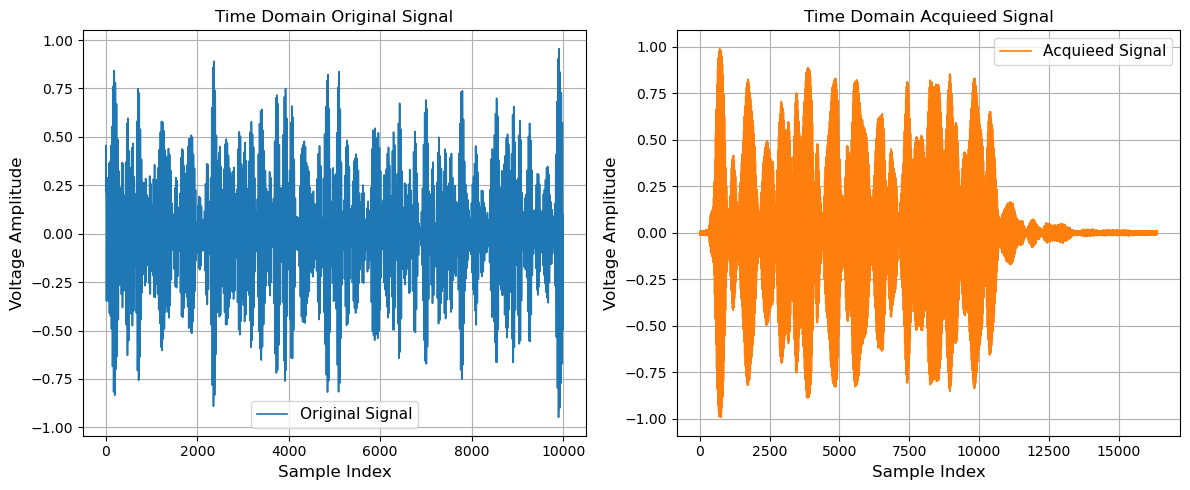

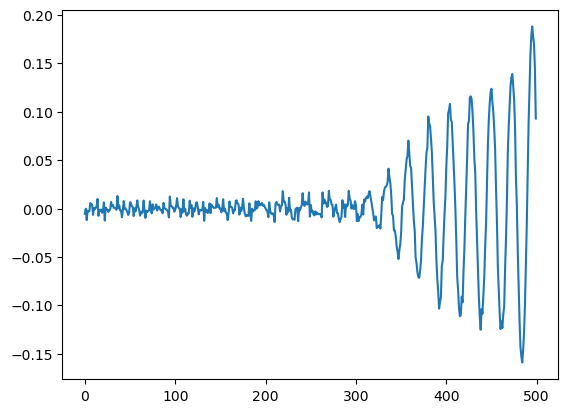

Peak value: 0.990478515625
Index of the peak: 713
Average Peak-to-Peak Value: 0.6632559767916055


In [348]:

# Release resources
rp.rp_Release()

threshold = 0.005
above_threshold_indices = np.where(data_V > threshold)[0]

if len(above_threshold_indices) > 0:
    first_rising_sample = above_threshold_indices[0]
    print(f"First sample above threshold: {first_rising_sample}")
    time_delay = first_rising_sample / sampling_rate * 1e6
    print(f"Calculated delay: {time_delay}")

    peaks, properties = find_peaks(data_V[200:900], height=0.1)
    # 2) Grab the amplitude at each peak:
    peak_values = data_V[200:900][peaks]
    
    print("Peak indices:", peaks)
    print("Peak values:", peak_values)
else:
    print("No samples above threshold.")



import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(np.arange(len(chirp_signal)), chirp_signal, color='C0', linewidth=1.2, label="Original Signal")
axs[0].set_title("Time Domain Original Signal", fontsize=12)
axs[0].set_xlabel("Sample Index", fontsize=12)
axs[0].set_ylabel("Voltage Amplitude", fontsize=12)
axs[0].grid(True)
axs[0].legend(fontsize=11)

axs[1].plot(np.arange(len(data_V)), data_V, color='C1', linewidth=1.2, label="Acquieed Signal")
axs[1].set_title("Time Domain Acquieed Signal", fontsize=12)
axs[1].set_xlabel("Sample Index", fontsize=12)
axs[1].set_ylabel("Voltage Amplitude", fontsize=12)
axs[1].grid(True)
axs[1].legend(fontsize=11)

plt.tight_layout()
plt.show()


plt.show()
plt.plot(data_V[0:500])
plt.show()

if SignalL == "3":
    threshold = 0.001
    window_size = 10  # choose a suitable window size based on sampling rate, etc.

    window = np.ones(window_size)/window_size
    smoothed_data = np.convolve(data_V, window, mode='same') + 0.005
    plt.plot(smoothed_data[0:500])
    plt.show()
    plt.plot(smoothed_data)
    plt.show()
    data_V_adjusted = smoothed_data
    
    data_V_thresholded = np.where(np.abs(data_V_adjusted[200:]) < threshold, 0, data_V_adjusted[200:])
    
    # Find indices where the thresholded data is not zero (i.e., above threshold)
    indices_above_threshold = np.where(data_V_thresholded != 0)[0]
    
    if indices_above_threshold.size > 0:
        first_index = indices_above_threshold[0]
        first_sample = data_V_thresholded[first_index]
        print(f"First sample above threshold: {first_sample} (at index {first_index + 200})")
    else:
        print("No samples are above the threshold.")


peak_value = np.max(data_V)
peak_index = np.argmax(data_V)
time_delay = peak_index / sampling_rate * 1e6

print(f"Peak value: {peak_value}")
print(f"Index of the peak: {peak_index}")
# print(f"Calculated delay: {time_delay}")

import numpy as np
import scipy.signal as signal

def average_peak_to_peak(data_V, sampling_rate, frequency):
    data_V = np.array(data_V)
    
    # Calculate the number of samples per cycle
    samples_per_cycle = int(sampling_rate / frequency)

    # Find peaks and troughs to split cycles
    num_cycles = len(data_V) // samples_per_cycle
    peak_to_peak_values = []

    for i in range(num_cycles):
        cycle_data = data_V[i * samples_per_cycle : (i + 1) * samples_per_cycle]
        pk_pk = np.max(cycle_data) - np.min(cycle_data)
        peak_to_peak_values.append(pk_pk)

    # Compute average peak-to-peak value
    avg_pk_pk = np.mean(peak_to_peak_values)

    return avg_pk_pk

frequency = 40000
avg_pk_pk = average_peak_to_peak(data_V, sampling_rate, frequency)
print(f"Average Peak-to-Peak Value: {avg_pk_pk}")

In [349]:
# dt = 1/fs

# # Assume these are already defined numpy arrays:
# # chirp_signal: shape (10000,)
# # data_V: shape (16384,)

# # For deconvolution, we need both signals to be of the same length.
# # We'll zero-pad chirp_signal to match data_V's length if needed.
# N_input = chirp_signal.shape[0]
# N_output = data_V.shape[0]
# if N_input < N_output:
#     chirp_signal_padded = np.pad(chirp_signal, (0, N_output - N_input), mode='constant')
# else:
#     chirp_signal_padded = chirp_signal.copy()

# # Compute the FFT of both signals
# fft_input = np.fft.fft(chirp_signal_padded)
# fft_output = np.fft.fft(data_V)

# # To avoid division by zero, add a small regularization factor to the input FFT
# epsilon = 1e-10
# fft_input_reg = np.where(np.abs(fft_input) < epsilon, epsilon, fft_input)

# # Compute the impulse response in the frequency domain by dividing output by input.
# fft_impulse_response = fft_output / fft_input_reg

# # Transform back to time domain to obtain the impulse response.
# impulse_response = np.fft.ifft(fft_impulse_response)
# # Due to numerical errors, the result might have a small imaginary part.
# impulse_response = np.real(impulse_response)

# # Apply the Hilbert transform to the impulse response.
# # This produces an analytic signal whose imaginary part is the Hilbert transform.
# analytic_signal = signal.hilbert(impulse_response)
# hilbert_impulse = np.imag(analytic_signal)

# # (Optional) Locate the zero-crossing of the Hilbert transform.
# # The zero crossing of the hyperbola indicates the time delay.
# zero_crossings = np.where(np.diff(np.sign(hilbert_impulse)))[0]
# if zero_crossings.size > 0:
#     # Convert index to time (in microseconds for readability)
#     delay_estimates = zero_crossings / fs * 1e6  
#     print("Zero-crossings (time delay estimates in µs):", delay_estimates)
# else:
#     print("No zero-crossing found in the Hilbert transform.")

# # Plot the impulse response and its Hilbert transform.
# t = np.arange(len(impulse_response)) / fs  # time vector in seconds

# plt.figure(figsize=(10, 4))
# plt.plot(t*1e6, impulse_response)
# plt.title("Impulse Response")
# plt.xlabel("Time (µs)")
# plt.ylabel("Amplitude")
# plt.grid(True)

# plt.figure(figsize=(10, 4))
# plt.plot(t*1e6, hilbert_impulse)
# plt.title("Hilbert Transform of Impulse Response")
# plt.xlabel("Time (µs)")
# plt.ylabel("Hilbert Transform")
# plt.grid(True)

# plt.figure(figsize=(10, 4))
# plt.plot(t*1e6, impulse_response)
# plt.title("Impulse Response")
# plt.xlabel("Time (µs)")
# plt.ylabel("Amplitude")
# plt.xlim(0, 100)  # zoom between 0 and 100 µs
# plt.grid(True)
# plt.show()

# # Plot the Hilbert transform of the impulse response zoomed between 0 and 100 µs
# plt.figure(figsize=(10, 4))
# plt.plot(t*1e6, hilbert_impulse)
# plt.title("Hilbert Transform of Impulse Response")
# plt.xlabel("Time (µs)")
# plt.ylabel("Hilbert Transform")
# plt.xlim(0, 100)  # zoom between 0 and 100 µs
# plt.grid(True)
# plt.show()


# plt.show()

In [350]:
### filter the acquired signal
if SignalL == "5" or SignalL == "1" or SignalL == "6":
    # target_length = 16384
    # if len(data_V) < target_length:
    #     noisy_signal = np.pad(data_V, 
    #                           (0, target_length - len(data_V)), 
    #                           mode='constant')
    X = fft(data_V)
    
    # List of the five H-values files
    if SignalL == "1":
        filenames = [
            "H_values_for_10cm_17degree_(1).txt",
            "H_values_for_10cm_17degree_(2).txt",
            "H_values_for_10cm_17degree_(3).txt",
            "H_values_for_10cm_17degree_(4).txt",
            "H_values_for_10cm_17degree_(5).txt"
        ]
    
    elif SignalL == "5":
        filenames = [
            "M_seq_H_values_for_10cm_17degree_(1).txt",
            "M_seq_H_values_for_10cm_17degree_(2).txt",
            "M_seq_H_values_for_10cm_17degree_(3).txt",
            "M_seq_H_values_for_10cm_17degree_(4).txt",
            "M_seq_H_values_for_10cm_17degree_(5).txt"
        ]
    elif SignalL == "6":
        filenames = [
            "tone_burst_H_values_for_10cm_(1).txt"
        ]
    # Read each file and store the complex H-values
    H_list = []
    for fname in filenames:
        data_read = np.loadtxt(fname, skiprows=1)  # skip first row
        # Convert columns to complex array: real + j*imag
        H_complex = data_read[:, 0] + 1j * data_read[:, 1]
        H_list.append(H_complex)
    
    # Average the complex H-values across all five files
    H_avg = np.mean(H_list, axis=0)
    
    # Pre-shape by dividing the original FFT by the averaged H-response
    pre_shaped_freq = X / H_avg
    
    # Convert back to time domain
    pre_shaped_signal = ifft(pre_shaped_freq)
    pre_shaped_signal = np.real(pre_shaped_signal)
    
    ############noise filtering@@@@@
    
    # Take the FFT of your pre_shaped_signal
    N = len(pre_shaped_signal)
    PS_fft = fft(pre_shaped_signal)
    
    # Frequency axis
    freqs = fftfreq(N, d=1/fs)
    
    # Create a band-pass mask for 35–45 kHz (both positive & negative freqs)
    band_mask = (np.abs(freqs) >= 35000) & (np.abs(freqs) <= 45000)
    
    # Zero out frequencies outside 35–45 kHz
    PS_fft_filtered = np.zeros_like(PS_fft)
    PS_fft_filtered[band_mask] = PS_fft[band_mask]
    
    # Reconstruct the band-pass-filtered time-domain signal
    pre_shaped_signal_bp = ifft(PS_fft_filtered).real
    
    # Mask for outside the 35–45 kHz band
    outside_mask = ~band_mask  # logical NOT of band_mask

    # Zero out chirp content within 35–45 kHz
    chirp_fft_outside = np.zeros_like(X)
    chirp_fft_outside[outside_mask] = X[outside_mask]
    
    combined_fft = PS_fft_filtered + chirp_fft_outside
    combined_signal = ifft(combined_fft).real
    
    
    data_V = combined_signal
    
    # for i in range(N_chirp): 
    #     data_V[i] = float(data_V[i])
    
    # chirp_signal = noisy_signal[:10000]



In [351]:
# 1) FFT of chirp_signal
# ---------------------
N_chirp = len(chirp_signal)
T_s = 1.0 / sampling_rate  # sampling period
yf_chirp = fft(chirp_signal)            # complex FFT result
xf_chirp = fftfreq(N_chirp, T_s)        # frequency bins from -Fs/2..+Fs/2

# Keep only the positive half for a real-valued signal
N_half_chirp = N_chirp // 2
xf_chirp_pos = xf_chirp[:N_half_chirp]
yf_chirp_pos = yf_chirp[:N_half_chirp]

# Convert to magnitude (and optionally dB)
mag_chirp = np.abs(yf_chirp_pos)
# mag_chirp_dB = 20.0 * np.log10(mag_chirp + 1e-12)

# ---------------------
# 2) FFT of data_V
# ---------------------
N_data = len(data_V)
yf_data = fft(data_V)
xf_data = fftfreq(N_data, T_s)

N_half_data = N_data // 2
xf_data_pos = xf_data[:N_half_data]
yf_data_pos = yf_data[:N_half_data]

mag_data = np.abs(yf_data_pos)

# ---------------------
# 3) Plot both on one figure
# ---------------------

if image == "show":
    plt.figure(figsize=(10, 6))
    
    # Linear magnitude (common approach)
    plt.plot(xf_chirp_pos, mag_chirp, label="Generated Chirp", linewidth=1.2)
    plt.plot(xf_data_pos,  mag_data,  label="Acquired Data",  linewidth=1.2)
    
    ## range
    plt.xlim(20e3, 70e3)
    
    plt.title("Chirp: Frequency-Domain Comparison")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Second peak at lag: 286


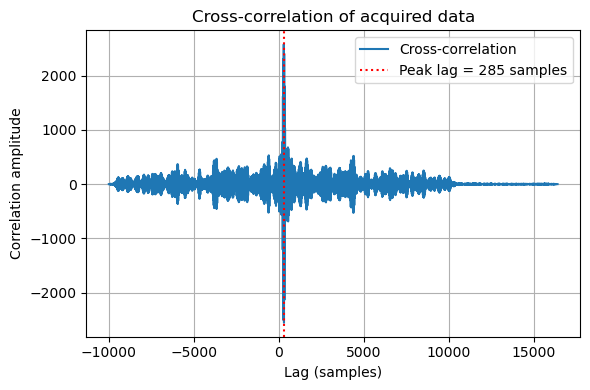

Peak correlation at lag = 285 samples
Calculated Time delay = 291.84000000000003 μs
Real Time delay = 0.000000e+00 seconds
26383


In [352]:
#### cross correlation ######
if SignalL == "2":
    real_delay= delay / sampling_rate
    chirp_signal_modified = envelope_cc * peak_value / signal_amplitude
    
    corr = correlate(envelope, chirp_signal_modified, mode='full')
    lags = correlation_lags(len(envelope), len(chirp_signal), mode='full')
else:
    real_delay= delay / sampling_rate
    chirp_signal_modified = chirp_signal * peak_value / signal_amplitude
    
    corr = correlate(data_V, chirp_signal_modified, mode='full')
    lags = correlation_lags(len(data_V), len(chirp_signal), mode='full')

# Find the index of the peak correlation
peak_idx = np.argmax(corr)         # index where correlation is maximum
if SignalL == "1" or SignalL == "5":
    best_lag = lags[peak_idx]          # lag in "samples"
else:
    best_lag = lags[peak_idx]          # lag in "samples"
# Suppress the first peak by setting it to a very low value
corr_suppressed = np.copy(corr)
corr_suppressed[peak_idx] = -np.inf  # or use a small value like np.min(corr)

# Find the second peak
second_peak_idx = np.argmax(corr_suppressed)
second_best_lag = lags[second_peak_idx]

time_delay = (best_lag) / sampling_rate * 1e6
print(f"Second peak at lag: {second_best_lag}")


# 2) Plot the Cross-Correlation
# -----------------------------------------------------------
plt.figure(figsize=(6, 4))
plt.plot(lags, corr, label='Cross-correlation')
plt.axvline(x=best_lag, color='r', linestyle=':', 
            label=f'Peak lag = {best_lag} samples')
plt.title("Cross-correlation of acquired data")
plt.xlabel("Lag (samples)")
plt.ylabel("Correlation amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 3) Report the delay
# -----------------------------------------------------------
print(f"Peak correlation at lag = {best_lag} samples")
print(f"Calculated Time delay = {time_delay} μs")
print(f"Real Time delay = {real_delay:.6e} seconds")

if not os.path.exists("results.txt"):
    with open("results.txt", "w") as f:
        f.write("best_lag, time_delay\n")

with open("results.txt", "a") as f:
    f.write(f"{best_lag}, {time_delay}\n")

print(len(corr))

In [353]:
# # Mapping from SignalL to waveform name
# waveform_map = {
#     "1": "linear_chirp",
#     "2": "tone_burst",
#     "3": "sine",
#     "4": "pulse",
#     "5": "m-sequence",
#     "6": "sine_wave_pulse"
# }

# # Get waveform name
# waveform_str = waveform_map.get(SignalL, "unknown")

# # Create base result directory
# base_dir = "longdistance"
# os.makedirs(base_dir, exist_ok=True)

# # Create waveform-specific folder under result/
# waveform_dir = os.path.join(base_dir, waveform_str)
# os.makedirs(waveform_dir, exist_ok=True)

# # Create filename
# today_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# if SignalL == "6":
#     filename = f"{today_str}_{waveform_str}_{best_lag}samples_num_cycles={num_cycles}.csv"
#     filepath = os.path.join(waveform_dir, filename)
# else:
#     filename = f"{today_str}_{waveform_str}_{best_lag}samples.csv"
#     filepath = os.path.join(waveform_dir, filename)
# # Write to CSV
# with open(filepath, mode='w', newline='') as file:
#     writer = csv.writer(file)

#     # Write metadata
#     writer.writerow(['sample_rate', sampling_rate])
#     writer.writerow(['signal_amplitude', signal_amplitude])
#     writer.writerow(['SignalL', SignalL])
#     writer.writerow(['best_lag', best_lag])
#     writer.writerow(['time_delay', time_delay])
#     writer.writerow(['num-of-cycles', num_cycles])
    
#     writer.writerow([])  # Spacer row

#     # Write data_V as column
#     writer.writerow(['data_V', 'corr'])

#     # Pad shorter list (data_V) with empty values
#     max_len = max(len(data_V), len(corr))
#     for i in range(max_len):
#         v = data_V[i] if i < len(data_V) else ""
#         c = corr[i] if i < len(corr) else ""
#         writer.writerow([v, c])


# print(f"File saved to {filepath}")



In [354]:
# from scipy.signal import stft


# sampling_rate = (125/128) * 1e6  # Sampling rate in Hz (~976562.5 Hz)
# freq_target = 40e3               # Target frequency in Hz (40 kHz)

# # data_V: received signal (16384 samples)
# # chirp_signal: input signal (10000 samples) - (not used directly for TOF calc)

# # --- STFT parameters ---
# nperseg = 128                   # Window length
# noverlap = nperseg // 2         # 50% overlap
# beta = 14                       # Kaiser window beta parameter
# window = np.kaiser(nperseg, beta)

# # Compute STFT of the received signal (data_V)
# # f: frequencies, t: segment times, Zxx: complex STFT values
# f, t, Zxx = stft(data_V, fs=sampling_rate, window=window, nperseg=nperseg, noverlap=noverlap)

# # Compute energy (magnitude squared) of the STFT
# energy = np.abs(Zxx)**2

# # --- Step 2: Identify the frequency band corresponding to 40 kHz ---
# # Find the index of the frequency bin closest to 40 kHz
# freq_idx = np.argmin(np.abs(f - freq_target))

# # Define a small band around the target frequency. 
# # Here we choose a few bins above and below the target bin.
# radius_freq = 2  # number of frequency bins on each side
# freq_min_idx = max(freq_idx - radius_freq, 0)
# freq_max_idx = min(freq_idx + radius_freq + 1, len(f))

# # Sum energy over the frequency band to create a time-domain energy profile
# energy_profile = np.sum(energy[freq_min_idx:freq_max_idx, :], axis=0)

# # --- Step 3: Determine the Time-of-Flight (TOF) ---
# # Find the time segment index where the energy profile is maximum
# time_idx_max = np.argmax(energy_profile)

# # To obtain a robust estimate, average the energy over a small neighborhood
# # around the peak in the time–frequency plane.
# radius_time = 2  # number of time bins on each side

# time_min_idx = max(time_idx_max - radius_time, 0)
# time_max_idx = min(time_idx_max + radius_time + 1, len(t))

# # Extract the local energy region (across the selected frequency band and time bins)
# local_energy = energy[freq_min_idx:freq_max_idx, time_min_idx:time_max_idx]

# # Compute the average energy within this region (if needed for diagnostics)
# avg_energy = np.mean(local_energy)

# # For a robust TOF, perform a weighted average of time over the neighborhood.
# # Average the energy across the frequency band for each time bin in the neighborhood.
# local_time_energy = np.mean(energy[freq_min_idx:freq_max_idx, time_min_idx:time_max_idx], axis=0)
# local_times = t[time_min_idx:time_max_idx]
# TOF = np.sum(local_times * local_time_energy) / np.sum(local_time_energy)

# print("Estimated Time-of-Flight (TOF): {:.6e} seconds".format(TOF))

# # --- Optional: Plot the STFT magnitude (in dB) and mark the estimated TOF ---
# plt.figure(figsize=(10, 4))
# plt.pcolormesh(t, f, 20*np.log10(np.abs(Zxx) + 1e-12), shading='gouraud')
# plt.axvline(x=TOF, color='r', linestyle='--', label=f'Estimated TOF: {TOF:.2e} s')
# plt.xlabel("Time (s)")
# plt.ylabel("Frequency (Hz)")
# plt.title("STFT Magnitude (dB)")
# plt.colorbar(label="Magnitude (dB)")
# plt.legend()
# plt.show()


In [355]:
# ## Zero-padding 
# target_length = 16384
# if len(noisy_signal) < target_length:
#     noisy_signal = np.pad(noisy_signal, 
#                           (0, target_length - len(noisy_signal)), 
#                           mode='constant')
# if len(data_V) < target_length:
#     data_V = np.pad(data_V, 
#                     (0, target_length - len(data_V)), 
#                     mode='constant')

# shift_amount = 285
# shifted_noisy_signal = np.zeros_like(noisy_signal)
# ## Move original samples to start at index = shift_amount
# shifted_noisy_signal[shift_amount:] = noisy_signal[:-shift_amount]
# noisy_signal = shifted_noisy_signal

# X = fft(noisy_signal)
# Y = fft(data_V)

# ## Compute magnitude ratio = |Y| / |X|
# epsilon = 1e-12
# H = Y / (X + epsilon)

# ### Pre-shape the reference
# pre_shaped_freq = X / H
# pre_shaped_signal = ifft(pre_shaped_freq)
# pre_shaped_signal = np.real(pre_shaped_signal)

# ## Plot for a quick comparison
# plt.figure()
# plt.plot(noisy_signal, label="Original Reference")
# plt.plot(data_V, label="Measured Output")
# plt.plot(pre_shaped_signal, label="Pre-Shaped (Amplitude-Only)", linestyle=':')

# plt.xlabel("Sample")
# plt.ylabel("Amplitude")
# plt.legend()
# plt.title("Magnitude-Only Pre-Shaping")
# plt.show()

# corr = correlate(data_V, pre_shaped_signal, mode='full')
# lags = correlation_lags(len(data_V), len(pre_shaped_signal), mode='full')

# # Find the index of the peak correlation
# peak_idx = np.argmax(corr)         # index where correlation is maximum
# best_lag = lags[peak_idx]          # lag in "samples"

# time_delay = (best_lag) / sampling_rate

# plt.plot(noisy_signal)
# plt.show

# ##### FIle name #####
# filename = "tone_burst_H_values_for_10cm_(1).txt"


# # 1) Save H in a text file with two columns: Real and Imaginary parts.
# data_to_save = np.column_stack((H.real, H.imag))
# # Using np.savetxt to write the file with a header. 'comments' is set to '' so the header is not commented out.
# np.savetxt(filename, data_to_save, header="Real\tImag", comments='')

# print(f"Saved H to {filename}.")

# F_original = fft(noisy_signal)
# F_measured = fft(data_V)
# F_preshaped = fft(pre_shaped_signal)

# len_original = len(noisy_signal)
# freqs = fftfreq(len_original, d=1.0/fs)

# if image == "show":
#     plt.figure(figsize=(10, 6))
#     plt.plot(freqs, np.abs(F_original), label='Original Signal')
#     # plt.plot(freqs, np.abs(F_measured), label='Measured Output')
#     plt.plot(freqs, np.abs(F_preshaped), label='Pre-Shaped Signal')
#     plt.title("Frequency Response (Linear Magnitude)")
#     plt.xlabel("Frequency (Hz)")
#     plt.ylabel("Magnitude")
#     plt.xlim(20e3, 70e3)
#     plt.legend()
#     plt.grid(True)
#     plt.show()